# Deep Linear Networks

Here, we repeat the experiments by [Jacot et al. (2022)](https://arxiv.org/abs/2106.15933), then [estimate SLT-derived invariants like the learning coefficient](https://github.com/edmundlth/scalable_learning_coefficient_with_sgld/blob/v1.0/experiment.py).

Currently, this only looks at the learning task behind figure 3 (not the MC loss behind figure 2).

A **deep linear network** (DLN) of length $L$ is a neural network with $L$ layers of widths $n_0, \dots, n_L$, that computes the transformation:

$$
\begin{align}
f: \mathbb{R}^{n_0} &\to \mathbb{R}^{n_L} \\
x &\mapsto W_L \cdots W_1 x =: A_\theta x,
\end{align}
$$

Parametrized by $\theta \in \mathbb{R}^P$, where $P = \sum_{l=1}^L n_{l-1} n_l$ is the number of parameters.

For convenience, we consider **rectangular networks**, or $(L, w)$-DLNs, with constant hidden width $w$ across all layers: $n_1 = \dots = n_{L-1} = w$.

## Hyperparameters

- $L$ is the number of layers
- $N=n_0$ is the input dimension
- $M=n_L$ is the output dimension
- $r$ is the rank of the "true" matrix / teacher $A^*$
- $w$ or $H$ is the hidden width (for rectangular networks).
- $\sigma$ is the teacher's output noise. By default, we use $\sigma=0$.


# Set-up

In [1]:
from typing import Optional, Union, List
from dataclasses import dataclass, field
import itertools

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy
from typing import Any, Type 

from devinterp.slt.sgld import SGLD
from devinterp.slt.ensemble import Ensemble
from devinterp.evals import dataloader_reduce, dataloader_map

In [2]:
# Define the model 

class DLN(nn.Module):
    """
    A deep linear network with `L` layers with dimensions `dims`.

    Weights are initialized with variance `init_variance`.
    """

    def __init__(self, dims: List[int], init_variance: float = 1.0):
        super().__init__()
        self.dims = dims
        self.L = len(dims) - 1
        self.init_variance = init_variance
        self.linears = nn.ModuleList([nn.Linear(d1, d2, bias=False) for d1, d2 in zip(dims[:-1], dims[1:])])

        # Initialize weights and biases
        for l in range(self.L):
            self.linears[l].weight.data.normal_(0, self.init_variance)  # Note: this is not normalized by the input dimension

    def forward(self, x):
        for l in range(self.L):
            x = self.linears[l](x)
        return x
    
    def __repr__(self):
        return f"DLN({self.dims})"
    
    @classmethod
    def make_rectangular(cls, input_dim: int, output_dim: int, L: int, w: int, gamma: float):
        """
        Make a rectangular DLN with `L` layers and constant hidden width `w`.

        The input dimension is `input_dim` and the output dimension is `output_dim`.

        The weights are initialized from a normal distribution with variance`w ** (-gamma)`.        
        """
        init_variance = w ** (-gamma)
        return cls([input_dim] + [w] * (L-1) + [output_dim], init_variance=init_variance)
    
    def to_matrix(self):
        """Return the collapsed matrix representation of the DLN."""
        return self.forward(torch.eye(self.dims[0])).T

    @classmethod
    def from_matrix(cls, A, L=1):
        if L != 1:
            raise NotImplementedError("Only L=1 is supported for now.")
        
        output_dim, input_dim = A.shape
        instance = cls([input_dim, output_dim])
        instance.linears[0].weight.data.copy_(A)

        print(instance.linears[0].weight.data)
        return instance
    
    def rank(self, **kwargs):
        """Return the rank of the DLN."""
        return torch.linalg.matrix_rank(self.to_matrix(), **kwargs)
    
    def ranks(self, **kwargs):
        """Return the ranks of the individual layers of the DLN."""
        return [torch.linalg.matrix_rank(l.weight.data, **kwargs) for l in self.linears]
    
    def norm(self, p: Union[int, float, str]=2):
        """Return the nuclear norm of the DLN."""
        return torch.norm(self.to_matrix(), p=p)
    
    def norms(self, p: Union[int, float, str]=2):
        """Return the nuclear norms of the individual layers of the DLN."""
        return [torch.norm(l.weight.data, p=p) for l in self.linears]

    def grad_norm(self, p=2, reduction="sum"):
        """Return the norm of the gradient of the DLN.
        
        If `reduction` is "sum", return the sum of the norms over all layers.
        If `reduction` is "none", return a list of the norms of the individual layers.

        """
        grad_norm = torch.zeros(self.L+1)

        if p != 2:
            raise NotImplementedError("Only p=2 is implemented.")

        grad_norms = [torch.sum(linear.weight.grad ** p) for linear in self.linears]

        if reduction == "sum":
            return sum(grad_norms)
        elif reduction != "none":
            raise ValueError(f"Unknown reduction {reduction}")
                    
        return grad_norm ** (1/p)

In [17]:
# RLCT estimation code

def individual_losses(model, dataloader):
    return dataloader_map(model, dataloader, {"mse": lambda m, x, y, yhat: torch.mean((y-yhat)**2, axis=1)})["mse"]

@dataclass
class SGLDChain:
    runs: List[np.ndarray]
    

@dataclass
class SGLDRun:
    chains: SGLDChain
    local_free_energy: float
    lambda_hat: float
    nu_hat: float


def estimate_rlct(
    ensemble, trainloader, num_iter=100, elasticity=1., lr=1e-5, verbose=True, **kwargs
):
    if verbose:
        print(f"Estimating RLCT with {ensemble.num_chains} chains, {num_iter} iterations, elasticity={elasticity}, lr={lr}")

    num_training_samples = len(trainloader.dataset)
    optimizer = SGLD(
        ensemble.parameters(), 
        lr=lr, 
        elasticity=elasticity, 
        temperature='adaptive',
        num_samples=num_training_samples,
        **kwargs
    )

    ensemble.train()
    ensemble.zero_grad()
    chain_Lms = [[] for _ in range(ensemble.num_chains)]

    for i, (inputs, labels) in zip(range(num_iter), itertools.cycle(trainloader)):
        for j, model in enumerate(ensemble):
            outputs = model(inputs)
            loss = F.mse_loss(outputs, labels)
            loss.backward(retain_graph=True)
            chain_Lms[j].append(loss.item())
        
        optimizer.step()
        optimizer.zero_grad()

    energy = chain_Lms[0][0] * num_training_samples
    chain_Lms = np.array(chain_Lms)
    local_free_energy = num_training_samples * np.mean(chain_Lms)
    chain_std = np.std(num_training_samples * np.mean(chain_Lms, axis=1))        

    hat_lambda = (local_free_energy - energy) / np.log(num_training_samples)

    if verbose:
        print(
            f"LFE: {local_free_energy} (std: {chain_std}, hat_lambda={hat_lambda}, energy={energy})"
        )
    
    return hat_lambda

In [4]:
# Define the learning tasks

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

class Task:
    def __init__(self, matrix: torch.Tensor, num_train_samples: int = 100, num_test_samples: int = 100, noise_level: float = 0.):
        self.matrix = matrix
        self.teacher = DLN.from_matrix(matrix)
        self.num_train_samples = num_train_samples
        self.num_test_samples = num_test_samples
        self.noise_level = noise_level

        self.train_data = self.gen_data(self.teacher, seed=0, noise_level=noise_level, num_samples=num_train_samples)
        self.test_data = self.gen_data(self.teacher, seed=0, noise_level=noise_level, num_samples=num_test_samples)
        self.train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=num_train_samples, shuffle=True)

    @staticmethod
    def gen_data(teacher: DLN, num_samples: int, seed=0, noise_level=0):
        set_seed(seed)
        
        num_features = teacher.to_matrix().shape[0]
        inputs = torch.rand(num_samples, num_features)
        labels = teacher(inputs) 
        labels += noise_level * torch.randn_like(labels)
        return torch.utils.data.TensorDataset(inputs, labels)

In [13]:
# Training run code

@dataclass
class Run:
    gamma: float = 1.
    w: int = 100
    L: int = 4
    input_dim: int = 5
    output_dim: int = 5
    seed: int = 0
    num_steps: int = 50_000
    lr: float = 1e-4
    student: Optional[DLN] = None
    train_errors: Optional[np.ndarray] = None
    test_errors: Optional[np.ndarray] = None
    ranks: Optional[np.ndarray] = None
    nuc_norms: Optional[np.ndarray] = None
    grad_norms: Optional[np.ndarray] = None
    subranks: Optional[np.ndarray] = None
    sub_nuc_norms: Optional[np.ndarray] = None
    rlcts: Optional[np.ndarray] = None
    eff_ranks: Optional[np.ndarray] = None 

def effective_rank(model: DLN, teacher_matrix: torch.Tensor):
    # Divide the first singular value by the first singular value of the teacher, and so on, then sum.
    # This needs a new name.
    singular_values = model.to_matrix().svd().S
    teacher_singular_values = teacher_matrix.svd().S
    missing_singular_values = teacher_singular_values == 0
    teacher_singular_values[missing_singular_values] = 1
    progress = (singular_values / teacher_singular_values)
    # Get rid of division by zero problems
    progress[progress == np.inf] = 0
    progress[progress == -np.inf] = 0
    progress[missing_singular_values] = 0

    return torch.sum(progress)

def fit(task, num_chains=5, num_iter=100, momentum=0.9, weight_decay=1e-4, elasticity=1., noise_level=1., lr=1e-4, sgld_lr=None, **kwargs) -> Run:
    train_data = task.train_loader.dataset
    run = Run(lr=lr, **kwargs)
    sgld_lr = sgld_lr or lr

    if run.student is None:
        run.student = DLN.make_rectangular(run.input_dim, run.output_dim, w=run.w, L=run.L, gamma=run.gamma)

    student = run.student
    optim = torch.optim.SGD(student.parameters(), lr=run.lr, momentum=momentum, weight_decay=weight_decay)

    train_errors = []
    test_errors = []
    ranks = []
    nuc_norms = []
    grad_norms = []
    rlcts = []
    eff_ranks = []
    subranks = []
    sub_nuc_norms = []

    ensemble = Ensemble(student, num_chains=num_chains)

    for i in tqdm(range(run.num_steps), desc="Training"):
        optim.zero_grad()
        loss = F.mse_loss(student(train_data.tensors[0]), train_data.tensors[1])
        loss.backward(retain_graph=True)
        optim.step()

        # if i % 100 == 0 or i < 2000:
        train_errors.append(loss.detach().numpy())
        # ranks.append(student.rank().detach().numpy())   
        # nuc_norms.append(student.norm(p="nuc").detach().numpy())
        grad_norms.append(student.grad_norm().detach().numpy())

        if i % 100 == 0:
            ensemble.reset()
            rlcts.append(estimate_rlct(ensemble, task.train_loader, verbose=False, num_iter=num_iter, elasticity=elasticity, noise_level=noise_level, lr=sgld_lr))
            eff_ranks.append(effective_rank(student, task.matrix).detach().numpy())
            subranks.append(np.array([r.detach().item() for r in student.ranks(atol=1e-1)]))
            sub_nuc_norms.append(np.array([n.detach().item() for n in student.norms(p="nuc")]))

        # with torch.no_grad():
        #     test_errors.append(F.mse_loss(student(test_data.tensors[0]), test_data.tensors[1]).detach().numpy())

    run.train_errors = np.array(train_errors)
    run.test_errors = np.array(test_errors)
    run.ranks = np.array(ranks)
    run.nuc_norms = np.array(nuc_norms)
    run.grad_norms = np.array(grad_norms)
    run.rlcts = np.array(rlcts)
    run.eff_ranks = np.array(eff_ranks)
    run.subranks = np.array(subranks)
    run.sub_nuc_norms = np.array(sub_nuc_norms)

    return run

In [14]:
# Visualizing runs

def plot_all(run: Run, xlog=False, figsize=(15, 4), title=None, smooth_rlcts=0):
    num_steps = run.num_steps

    fig, axes = plt.subplots(1, 4, figsize=figsize)

    axes[0].set_title("Train error")
    axes[0].plot(np.arange(num_steps), run.train_errors, label="Train")
    axes[0].set_yscale("log")

    # clip to positive values
    rlcts = np.clip(run.rlcts, 0, None)

    if smooth_rlcts:
        # Prepend and append RLCTs with the first and last values
        rlcts = np.concatenate([[rlcts[0]] * smooth_rlcts, rlcts, [rlcts[-1]] * smooth_rlcts])
        rlcts = np.convolve(rlcts, np.ones(smooth_rlcts) / smooth_rlcts, mode="same")
        rlcts = rlcts[smooth_rlcts:-smooth_rlcts]

    # rlcts = sample_run.rlcts
    axes[1].set_title("RLCTs")
    axes[1].plot(np.linspace(0, num_steps, len(rlcts)), rlcts, label="RLCT")
    # axes[1].set_yscale("log")

    axes[2].set_title("Effective rank")
    axes[2].plot(np.arange(0, num_steps, 100), run.eff_ranks, label="Grad norm")

    # plt.title("Subranks")
    # for l in range(run.L):
    #     plt.plot(np.arange(0, num_steps, 100), [e[l] for e in run.subranks], label=str(l))
    # # plt.yscale("log")
    # plt.legend()
    # plt.show()

    axes[3].set_title("Nuclear norms")
    for l in range(run.L):
        axes[3].plot(np.arange(0, num_steps, 100), [e[l] for e in run.sub_nuc_norms], label=str(l))
    # axes[3].set_yscale("log")
    axes[3].legend()

    for ax in axes:
        ax.set_xlabel("Step")
        if xlog:
            ax.set_xscale("log")

    if title is not None:
        fig.suptitle(title)
    
    plt.tight_layout()
    plt.show()

# Experiments

In [21]:
# Defining all the teacher matrices

# Rank 5
rk5_matrix = torch.Tensor(10 * np.diag(np.arange(1, 6)))
set_seed(0)
rk5_task = Task(rk5_matrix)
set_seed(0)
rk5_err2_task = Task(rk5_matrix, noise_level=10)

# Rank 4
rk4_matrix = rk5_matrix.clone()
rk4_matrix[-1, -1] = 0
set_seed(0)
rk4_task = Task(rk4_matrix)
set_seed(0)
rk4_err2_task = Task(rk4_matrix, noise_level=10)

# Rank 2
rk2_matrix = rk5_matrix.clone()
rk2_matrix[-1, -1] = 0
rk2_matrix[-2, -2] = 0
rk2_matrix[-3, -3] = 0
set_seed(0)
rk2_task = Task(rk2_matrix)
set_seed(0)
rk2_err2_task = Task(rk2_matrix, noise_level=10)

default_kwargs = {"num_iter": 20, "num_chains": 50, "lr": 1e-3, "num_steps": 10_000, "gamma": 1.1, "sgld_lr": 1e-5, "noise_level": 0.5} # Gamma > 1 puts us slightly in the saddle-to-saddle regime

tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0., 50.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0., 50.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  

In [22]:
run_rk5_L4_w10 = fit(rk5_task, w=10, L=4, **default_kwargs)
plot_all(run_rk5_L4_w10, xlog=False, title="r=5, L=4, w=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

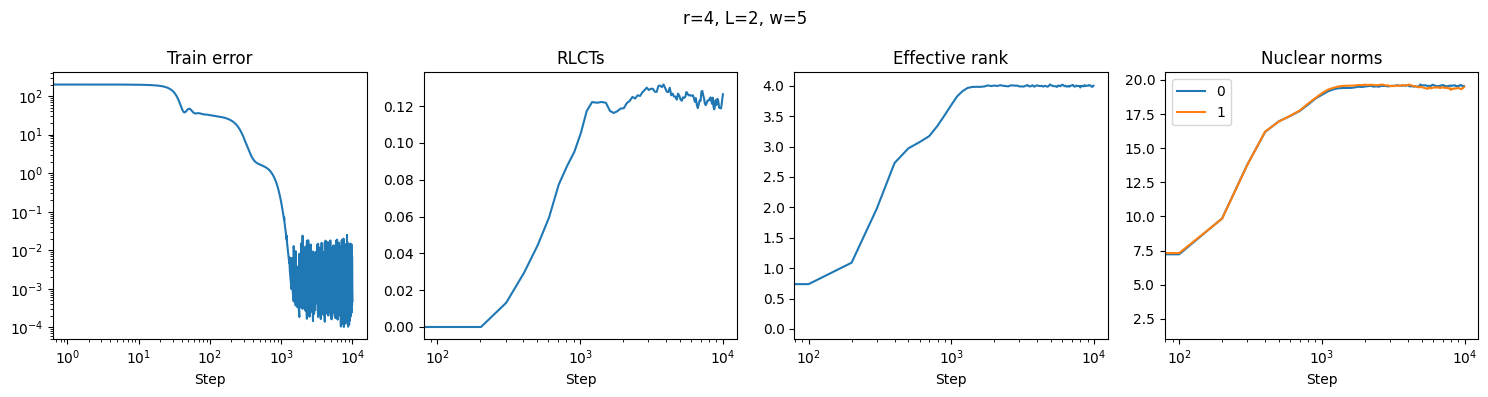

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

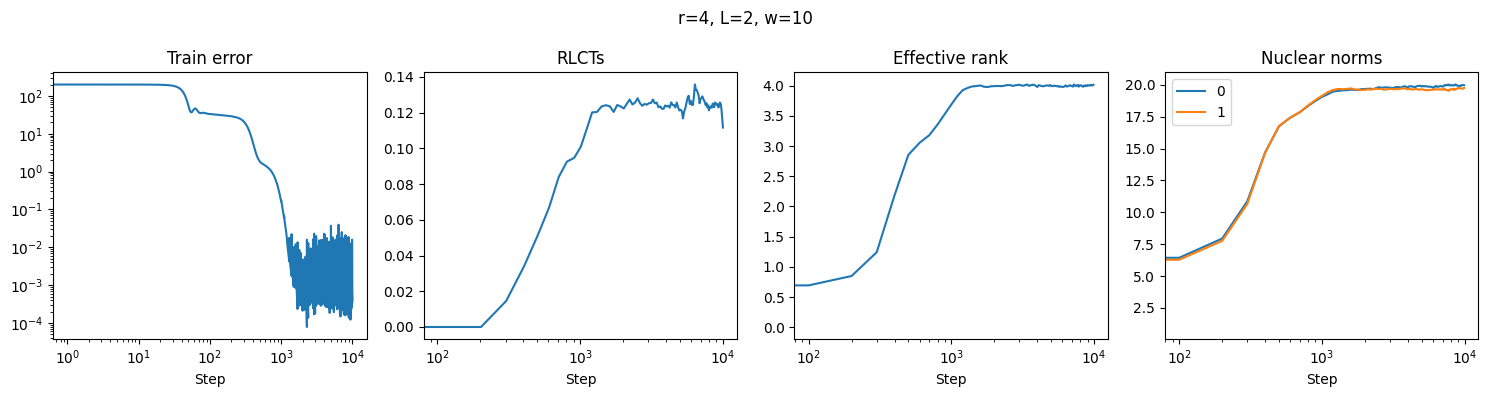

In [24]:
run_rk4_L2_w5 = fit(rk4_task, w=5, L=2, **default_kwargs)
plot_all(run_rk4_L2_w5, xlog=True, title="r=4, L=2, w=5", smooth_rlcts=5)

run_rk4_L2_w10 = fit(rk4_task, w=10, L=2, **default_kwargs)
plot_all(run_rk4_L2_w10, xlog=True, title="r=4, L=2, w=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

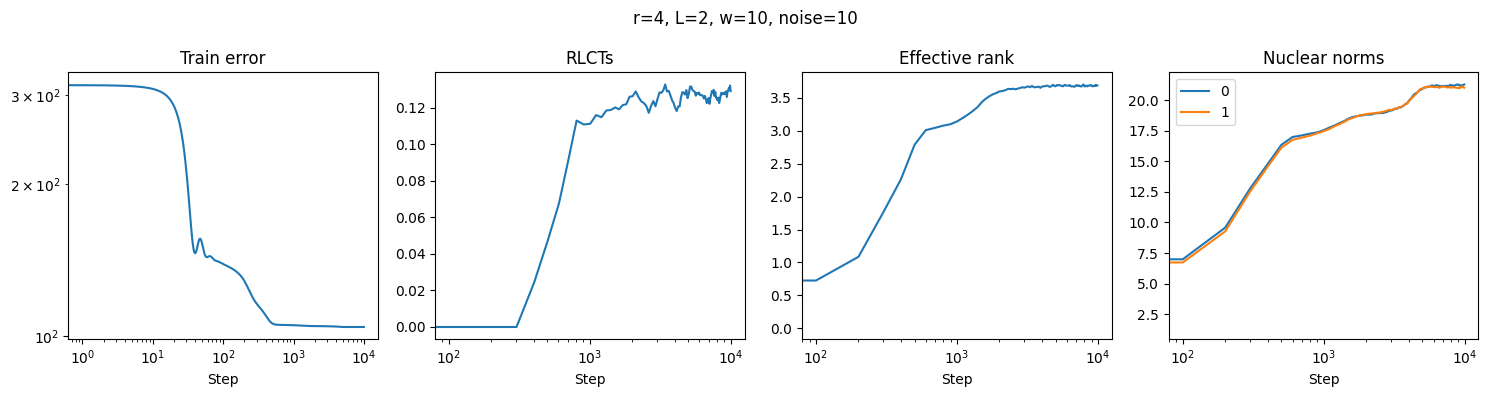

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

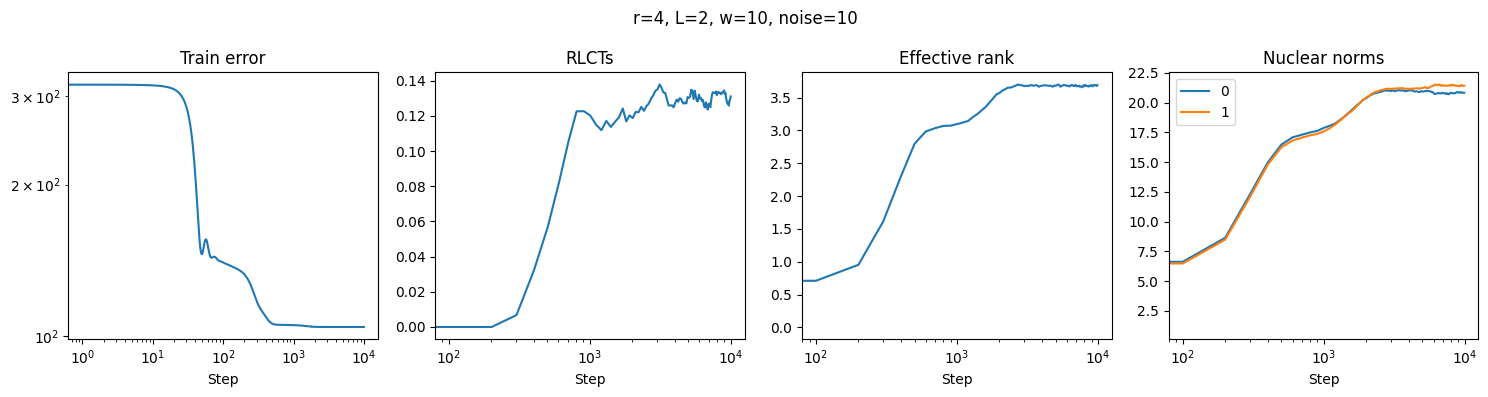

In [25]:
run_rk4_err2_L2_w5 = fit(rk4_err2_task, w=5, L=2, **default_kwargs)
plot_all(run_rk4_err2_L2_w5, xlog=True, title="r=4, L=2, w=10, noise=10", smooth_rlcts=5)

run_rk4_err2_L2_w10 = fit(rk4_err2_task, w=10, L=2, **default_kwargs)
plot_all(run_rk4_err2_L2_w10, xlog=True, title="r=4, L=2, w=10, noise=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

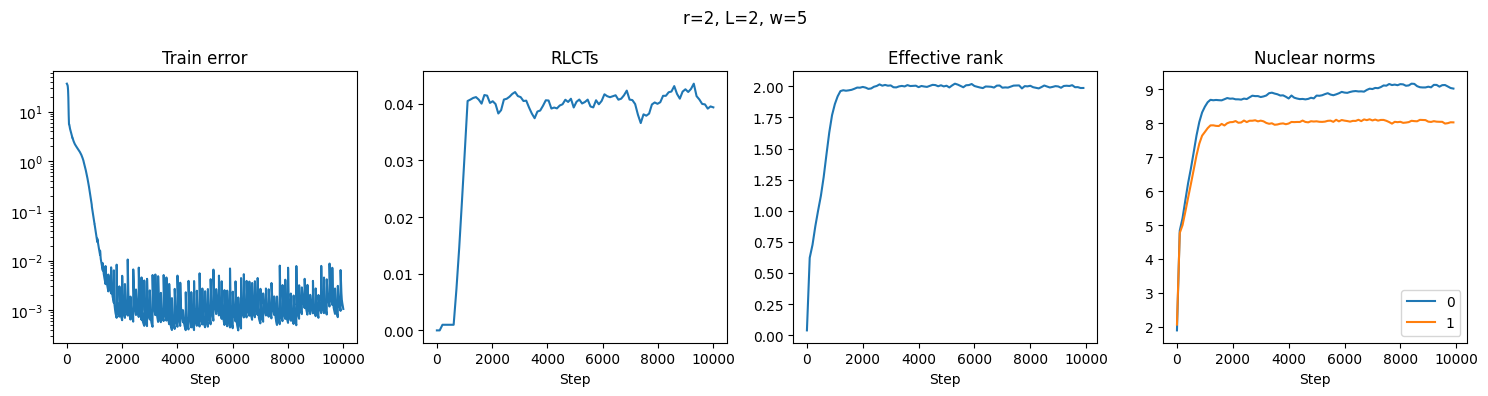

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

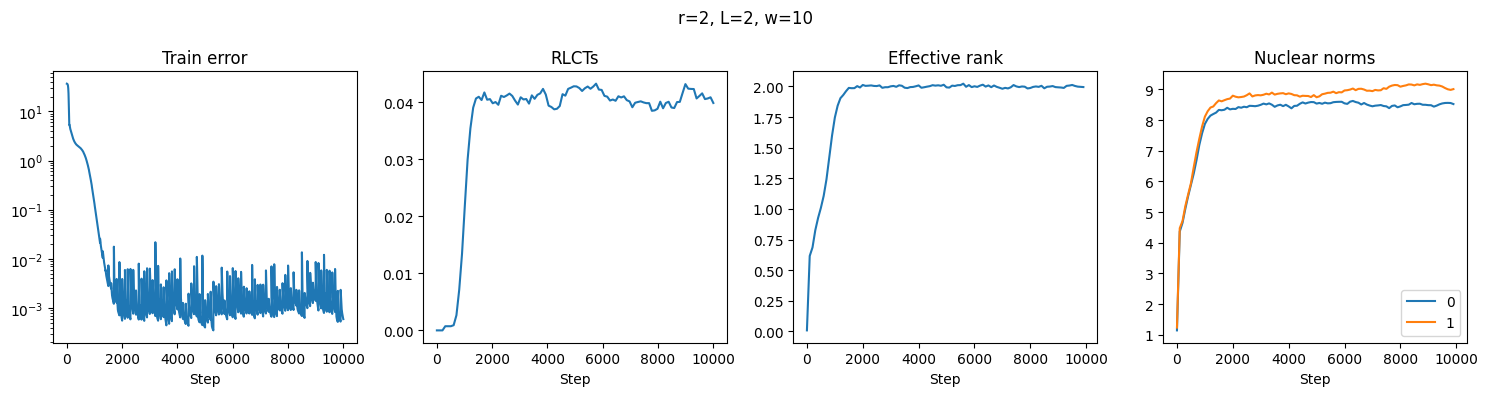

In [26]:
# N = 5, Rank = 2, L = 2 (1 hidden state)
run_rk2_L2_w5 = fit(rk2_task, w=5, L=2, **default_kwargs)
plot_all(run_rk2_L2_w5, xlog=False, title="r=2, L=2, w=5", smooth_rlcts=5)

run_rk2_L2_w10 = fit(rk2_task, w=10, L=2, **default_kwargs)
plot_all(run_rk2_L2_w10, xlog=False, title="r=2, L=2, w=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

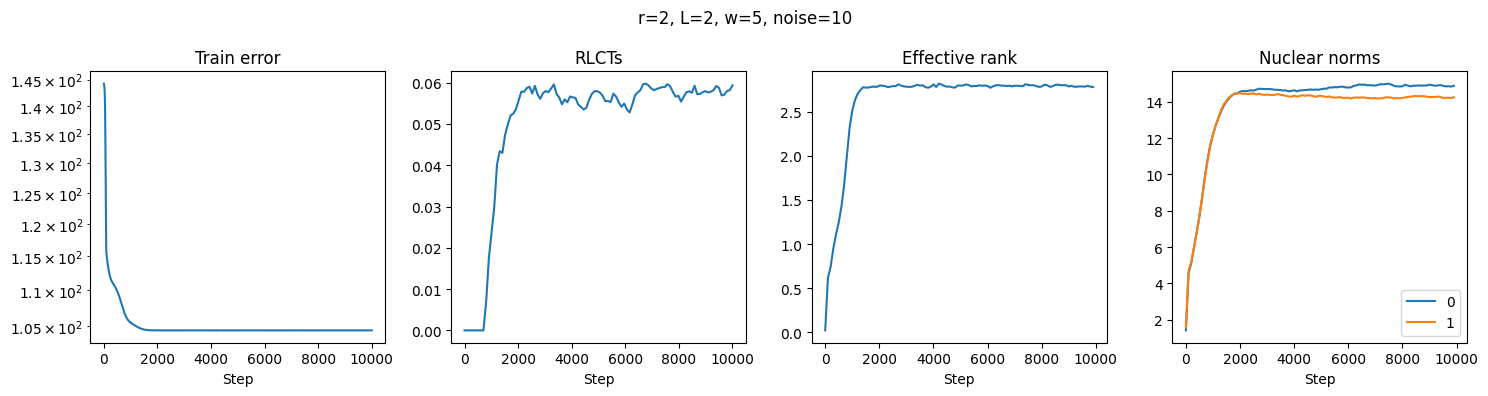

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

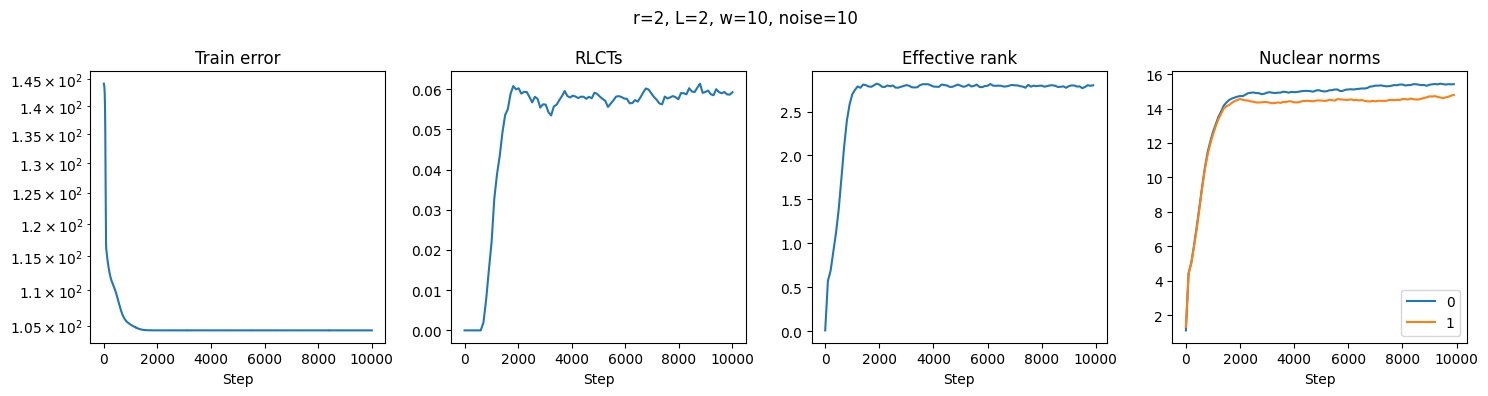

In [27]:
# N = 5, Rank = 2, L = 2 (1 hidden state)
run_rk2_err2_L2_w5 = fit(rk2_err2_task, w=5, L=2, **default_kwargs)
plot_all(run_rk2_err2_L2_w5, xlog=False, title="r=2, L=2, w=5, noise=10", smooth_rlcts=5)

run_rk2_err2_L2_w10 = fit(rk2_err2_task, w=10, L=2, **default_kwargs)
plot_all(run_rk2_err2_L2_w10, xlog=False, title="r=2, L=2, w=10, noise=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

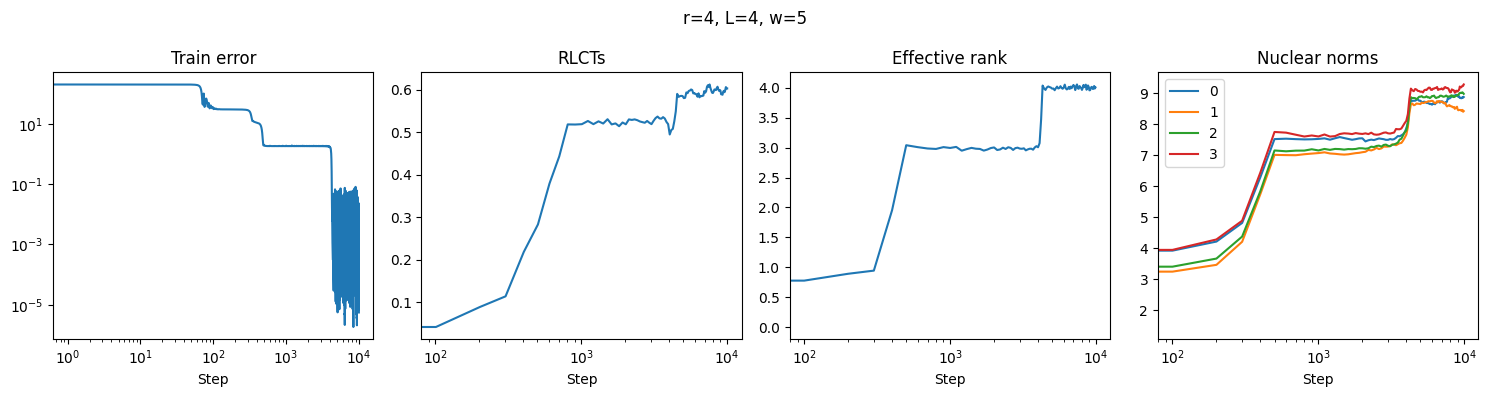

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

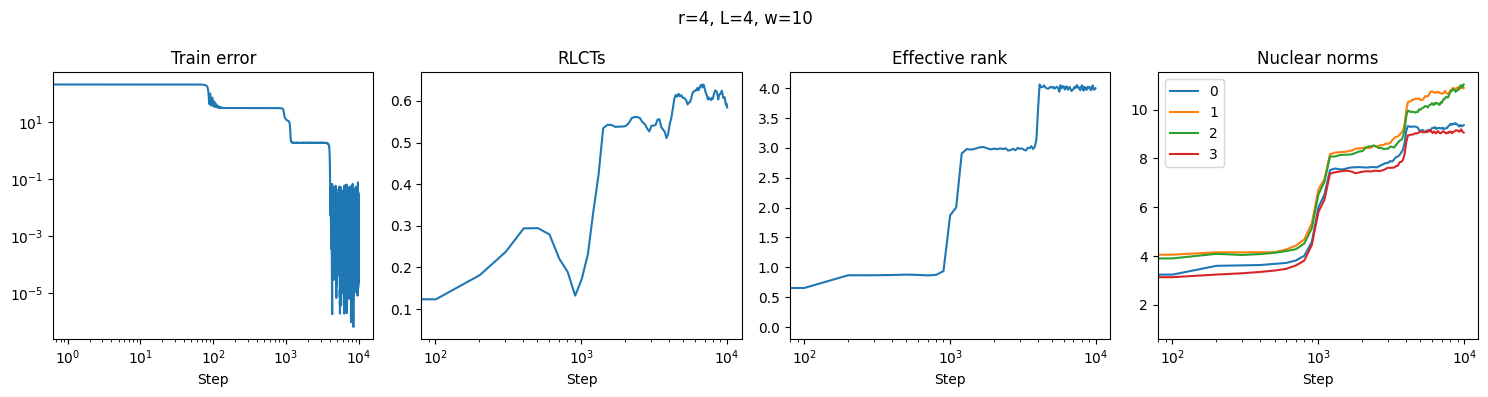

In [28]:
run_rk4_L4_w5 = fit(rk4_task, w=5, L=4, **default_kwargs)
plot_all(run_rk4_L4_w5, xlog=True, title="r=4, L=4, w=5", smooth_rlcts=5)

run_rk4_L4_w10 = fit(rk4_task, w=10, L=4, **default_kwargs)
plot_all(run_rk4_L4_w10, xlog=True, title="r=4, L=4, w=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

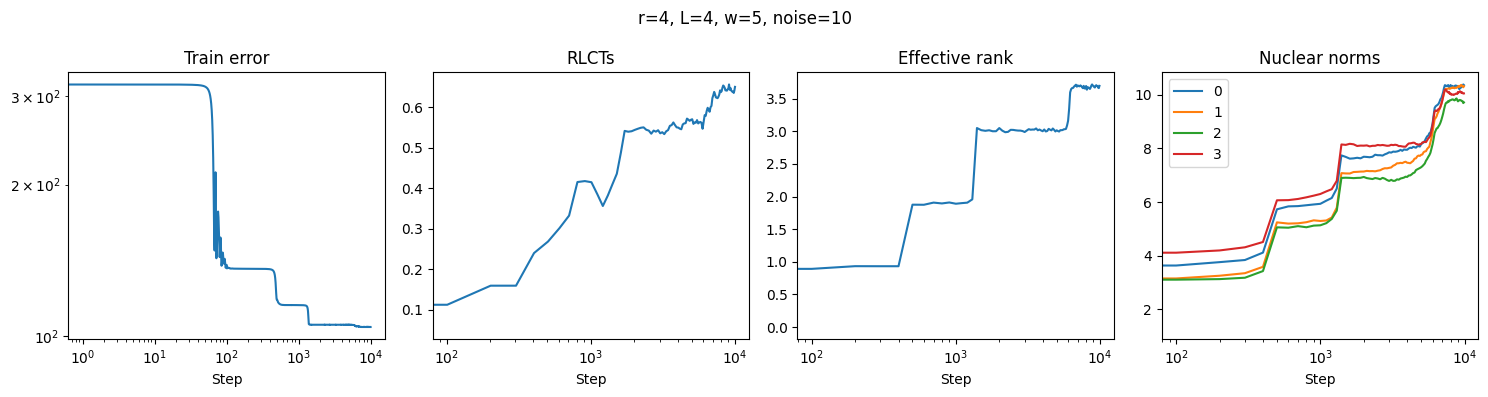

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

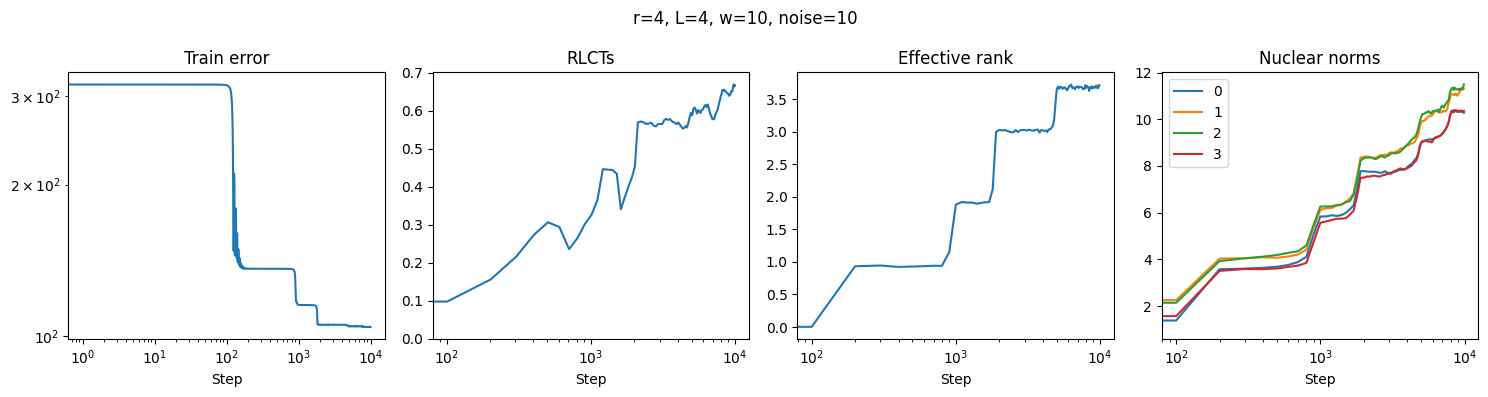

In [29]:
run_rk4_err2_L4_w5 = fit(rk4_err2_task, w=5, L=4, **default_kwargs)
plot_all(run_rk4_err2_L4_w5, xlog=True, title="r=4, L=4, w=5, noise=10", smooth_rlcts=5)

run_rk4_err2_L4_w10 = fit(rk4_err2_task, w=10, L=4, **default_kwargs)
plot_all(run_rk4_err2_L4_w10, xlog=True, title="r=4, L=4, w=10, noise=10", smooth_rlcts=5)

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

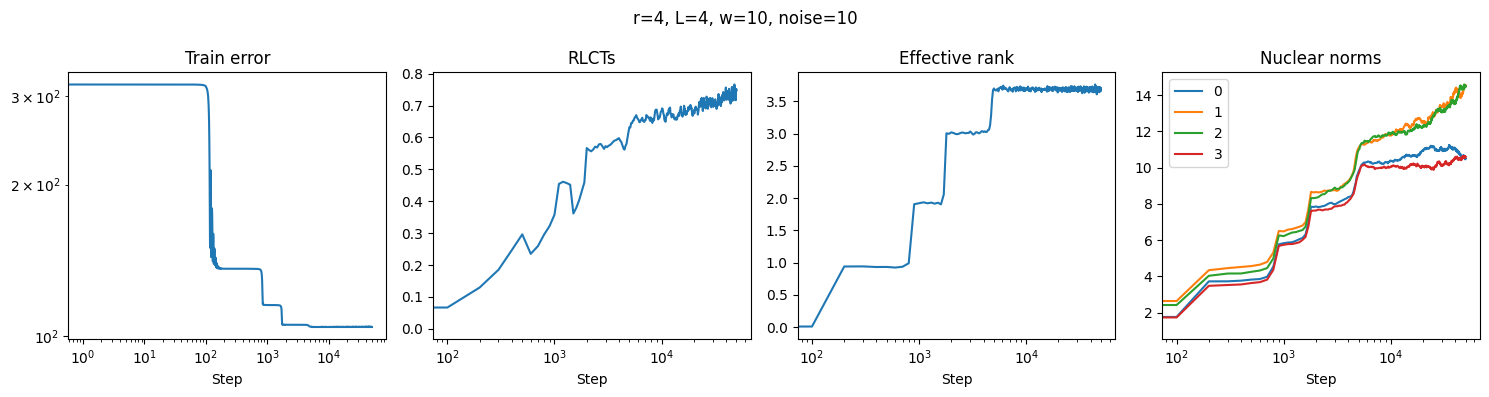

In [32]:
kwargs = default_kwargs.copy()
kwargs["num_steps"] = 50_000

run_rk4_err2_L4_w10 = fit(rk4_err2_task, w=10, L=4, **kwargs)
plot_all(run_rk4_err2_L4_w10, xlog=True, title="r=4, L=4, w=10, noise=10", smooth_rlcts=5)


# Recreate figure 5

In [59]:
@dataclass
class Runs:
    runs: List[Run] = field(default_factory=list)

    def filter(self, **kwargs):
        return Runs([run for run in self.runs if self.matches(run, **kwargs)])

    @staticmethod
    def matches(run, **kwargs):
        return all([getattr(run, k) == v for k, v in kwargs.items()])
    
    def __iter__(self):
        return iter(self.runs)
    
    def __len__(self):
        return len(self.runs)
    
    def __getitem__(self, i):
        return self.runs[i]
    
    def __repr__(self):
        return f"Runs({self.runs})"
    
    def __add__(self, other):
        return Runs(self.runs + other.runs)
    
    def __iadd__(self, other):
        self.runs += other.runs
        return self
    
    def append(self, run):
        self.runs.append(run)

runs = Runs()


# Define a unique set of gammas
gammas = [0.75, 1., 1.5]
ws = [10, 100]

for gamma, w in tqdm(list(itertools.product(gammas, ws)), desc="Sweeping"):
    runs.append(fit(train_loader, gamma=gamma, w=w))


Sweeping:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

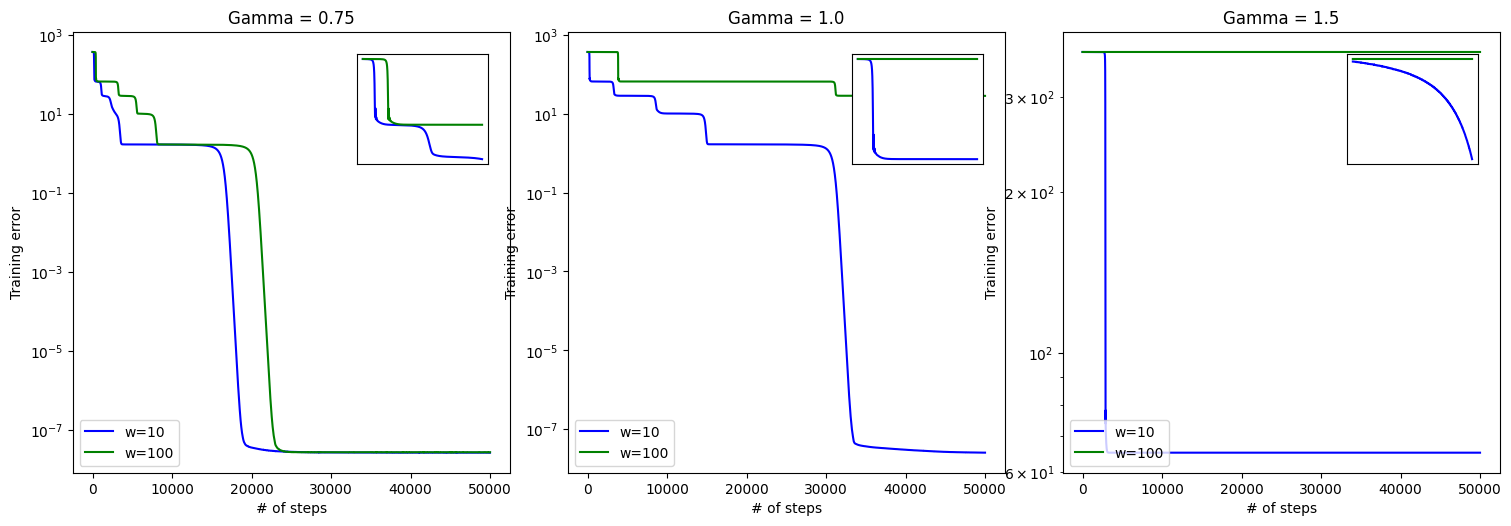

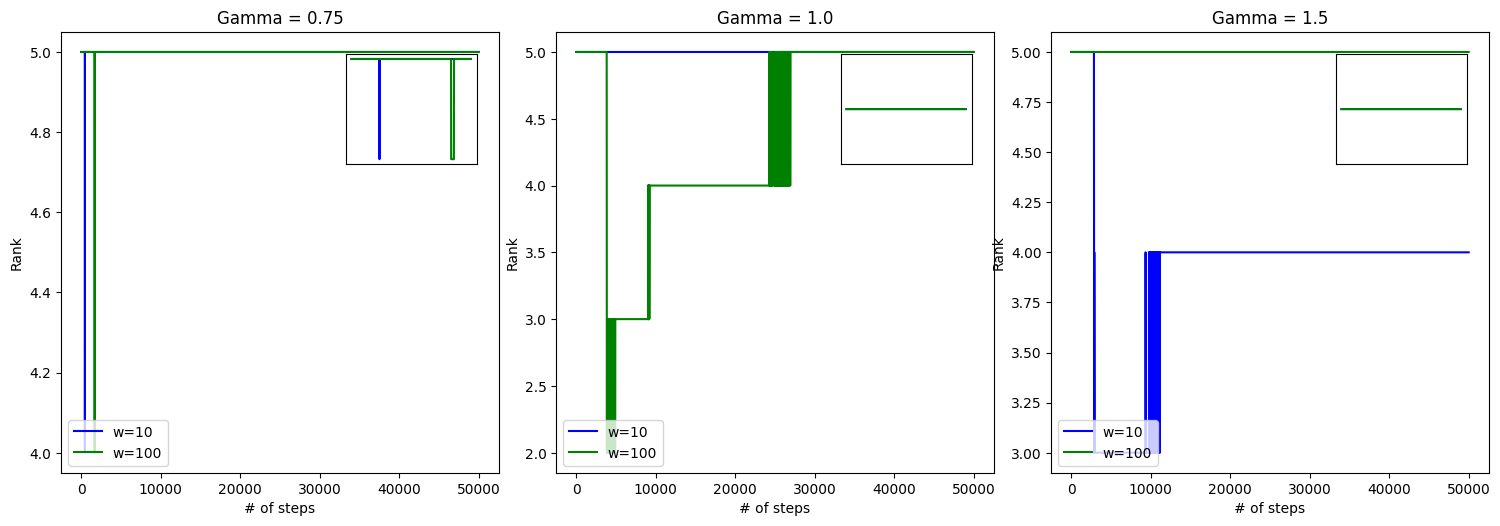

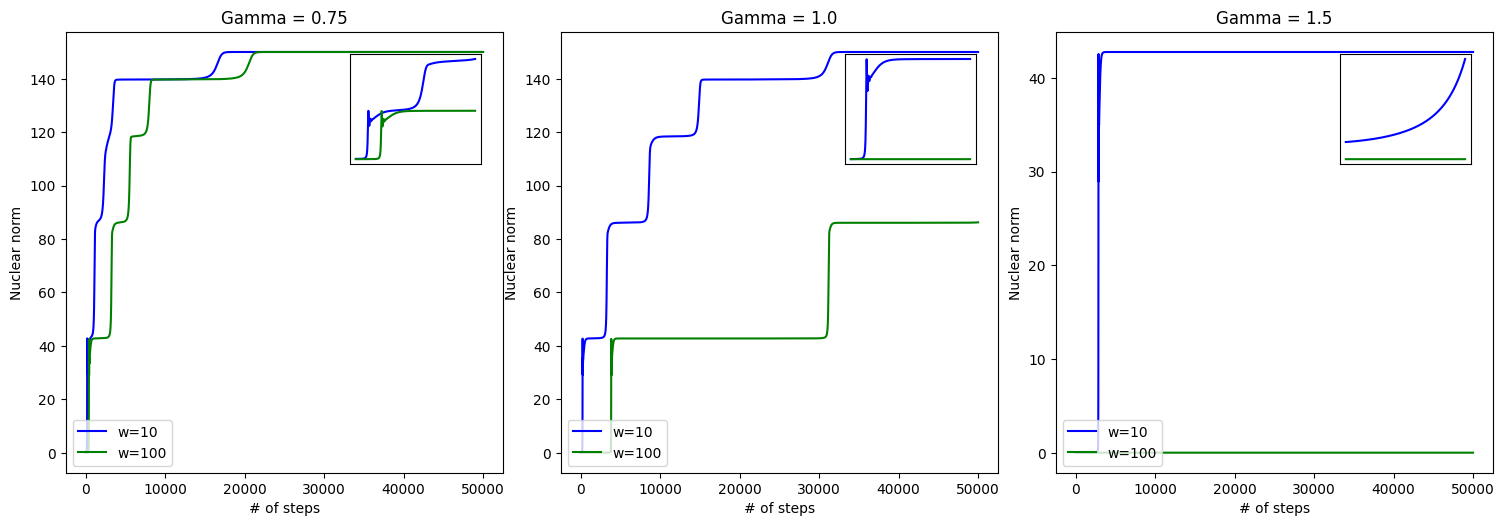

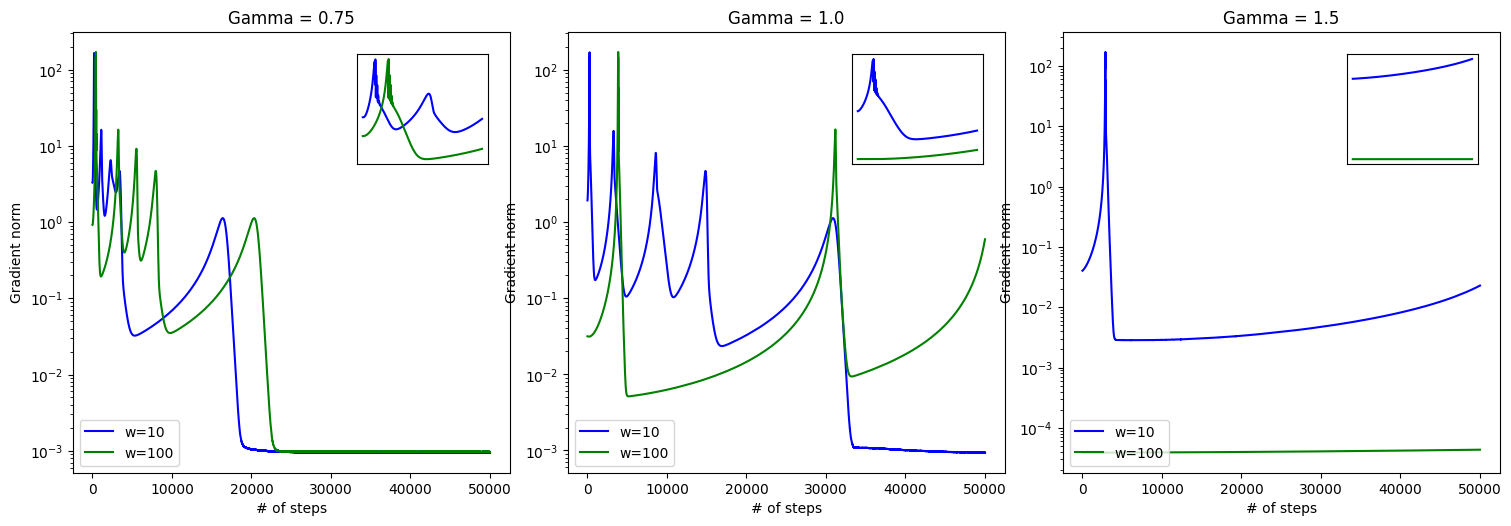

In [17]:
import matplotlib.pyplot as plt

def plot(runs: Runs, metric: str, ylabel: str, title: str, logscale: bool = False):

    # Define the colors for each w value
    colors = {10: 'b', 100: 'g'}

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    fig.tight_layout()


    # Iterate through the unique gammas
    for i, gamma in enumerate(gammas):
        ax = axes[i]
        # Add an inset focusing on the first 2000 steps
        ax_inset = ax.inset_axes([0.65, 0.7, 0.3, 0.25])

        # Iterate through the runs, filtering by the current gamma
        for run in runs.filter(gamma=gamma):
            values = getattr(run, metric)
            w = run.w
            color = colors[w]
            
            # Plot the training error against the number of steps
            ax.plot(values, color=color, label=f'w={w}')
            ax_inset.plot(values[:2000], color=color)
        
        ax_inset.yaxis.set_visible(False)
        ax_inset.xaxis.set_visible(False)
        ax.set_xlabel('# of steps')
        ax.set_ylabel(ylabel)
        
        if logscale:
            ax_inset.set_yscale('log')
            ax.set_yscale('log')

        ax.set_title(f'Gamma = {gamma}')
        ax.legend(loc='lower left') 

    plt.show()

plot(runs, 'train_errors', 'Training error', 'Training error', logscale=True)
# plot(runs, 'test_errors', 'Test error', 'Test error', logscale=True)
plot(runs, 'ranks', 'Rank', 'Rank', logscale=False)
plot(runs, 'nuc_norms', 'Nuclear norm', 'Nuclear norm', logscale=False)
plot(runs, 'grad_norms', 'Gradient norm', 'Gradient norm', logscale=True)

# Calibrate RLCT estimation

I still don't trust the RLCT estimation. Let's try to calibrate it against easy landscapes (like $K(w) = w^k$, in multiindex notation).

In [16]:
def demo_estimate_rlct(
    exponents, num_iter=50, num_chains=10, elasticity=1., lr=1e-3, verbose=True, num_training_samples=1000
):
    if verbose:
        print(f"Estimating RLCT with {num_chains} chains, {num_iter} iterations, elasticity={elasticity}, lr={lr}")

    num_weights = len(exponents)
    inputs = torch.randn((num_training_samples, 1))
    outputs = torch.randn((num_training_samples)) / 4.  # True weights are 0

    trainloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(inputs, outputs), batch_size=num_training_samples, shuffle=True
    )

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.weights = nn.Parameter(torch.rand(num_weights, 1))

            for param in self.parameters():
                # param.data = torch.zeros_like(param.data)
                # Uniform initialization
                param.data = torch.rand_like(param.data)

        def forward(self, x):
            return (self.weights ** exponents).prod() * x

    model = Model()
    ensemble = Ensemble(model, num_chains=num_chains)

    return estimate_rlct(ensemble, trainloader, num_iter, elasticity, lr, verbose)

kwargs = {"elasticity": 10, "lr": 1e-4, "num_chains": 200, }

for (num_iter, num_training_samples) in itertools.product((50, ), (100, 1000)):
    torch.manual_seed(0)
    np.random.seed(0)
    print("=" * 80)
    print("num_iter", num_iter, "n", num_training_samples, "\n\n")
    print("0.17", demo_estimate_rlct(torch.Tensor([1, 3]), num_iter=num_iter, num_training_samples=num_training_samples, **kwargs), "\n\n")
    print("0.25", demo_estimate_rlct(torch.Tensor([1, 2]), num_iter=num_iter, num_training_samples=num_training_samples, **kwargs), "\n\n")
    print("0.5", demo_estimate_rlct(torch.Tensor([0, 1]), num_iter=num_iter, num_training_samples=num_training_samples, **kwargs), "\n\n")
    print("0.5", demo_estimate_rlct(torch.Tensor([1, 0]), num_iter=num_iter, num_training_samples=num_training_samples, **kwargs), "\n\n")

num_iter 50 n 100 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_32196/84508738.py:88: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, labels)


LFE: 5.469874960035086 (std: 9.453744865994837e-05, hat_lambda=5.483910031572961e-06, energy=5.469849705696106)
0.17 5.483910031572961e-06 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 14.832147010117769 (std: 3.510025629016961, hat_lambda=0.1556883625015658, energy=14.115175604820251)
0.25 0.1556883625015658 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 7.569538586735726 (std: 0.09283345148493696, hat_lambda=0.0067754436967449065, energy=7.538336515426636)
0.5 0.0067754436967449065 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 11.698973327130078 (std: 1.0746709782797499, hat_lambda=0.01471329301515475, energy=11.63121610879898)
0.5 0.01471329301515475 


num_iter 50 

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_32196/84508738.py:88: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, labels)


LFE: 59.028003710880874 (std: 0.07785689430303935, hat_lambda=0.004821850991068008, energy=58.99469554424286)
0.17 0.004821850991068008 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 59.74203035831451 (std: 0.000206702762866631, hat_lambda=6.0193504995960186e-06, energy=59.74198877811432)
0.25 6.0193504995960186e-06 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 753.7256665110588 (std: 86.76111090497066, hat_lambda=-1.0461355760282502, energy=760.9521150588989)
0.5 -1.0461355760282502 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 76.19573036283255 (std: 4.975781513257275, hat_lambda=0.09832441279787967, energy=75.51652938127518)
0.5 0.09832441279787967 




# Some tests

In [ ]:
def test_from_matrix():
    # Set dimensions and number of layers
    input_dim = 5
    output_dim = 3
    L = 1

    # Create a random matrix
    A = torch.randn((output_dim, input_dim))

    # Create a DLN from the matrix
    dln_from_matrix = DLN.from_matrix(A, L=L)

    # Use the DLN's to_matrix method to get the matrix representation
    A_from_dln = dln_from_matrix.to_matrix()

    # Check if the matrices are close to each other
    torch.testing.assert_allclose(A, A_from_dln, atol=1e-5, rtol=1e-5)

test_from_matrix()